In [1]:
import pandas as pd
import os
import numpy as np
import glidertools as gt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import date
import cmocean
import netCDF4
from netCDF4 import Dataset
import xarray as xa

import operator as op
plt.style.use(['default'])
#pd.set_option('display.max_rows', None)

In [3]:
# full path to datafiles
filenames_16m = "/Users/anjalishah/Desktop/EcoFOCI2024/Data/Mooring_Sites/M5/M5_ncdf/22bs5a_ecf_0016m.nc"

# pull out only science variables
names = [
    'chlor_fluorescence_QC',
    'latitude',
    'longitude',
    'time'
]

M5_data_16m = xa.open_dataset(filenames_16m)


filenames_15m = "/Users/anjalishah/Desktop/EcoFOCI2024/Data/Mooring_Sites/M5/M5_ncdf/22bs5a_s37_0015m.nc"

names = ['temperature', 'salinity', 'time']
M5_data_15m = xa.open_dataset(filenames_15m)

In [5]:
#function that QC's chlorophyll data and creates a timeseries dataframe
def calc_chlor_QC(mooring_data, flag): 
    QC = mooring_data.chlor_fluorescence_QC.values[:, 0, 0, 0]
    time = mooring_data.chlor_fluorescence.time
    chlor = mooring_data.chlor_fluorescence.values[:, 0, 0, 0]
    final_chlor = np.zeros(len(time))
    print(np.unique(QC)) # identify flagged values (=4, bad data)
    op.countOf(QC, flag) #count how many occurrences
    for i, qc in enumerate(QC):
        if qc==4:
            final_chlor[i]=0
        else:
            final_chlor[i]=chlor[i]
    final_chlor_timeseries = pd.DataFrame(data = final_chlor, index = time, columns=['chl uG/L'])
    return final_chlor_timeseries

final_M5_chlor = calc_chlor_QC(M5_data_16m, 4)

final_M5_chlor_avg = final_M5_chlor.rolling(7).mean()

print(final_M5_chlor_avg)

[0. 1. 4.]
                     chl uG/L
2022-09-07 00:00:00       NaN
2022-09-07 01:00:00       NaN
2022-09-07 02:00:00       NaN
2022-09-07 03:00:00       NaN
2022-09-07 04:00:00       NaN
...                       ...
2023-08-30 18:00:00  4.699399
2023-08-30 19:00:00  4.647525
2023-08-30 20:00:00  4.546496
2023-08-30 21:00:00  4.405477
2023-08-30 22:00:00  4.285927

[8591 rows x 1 columns]


In [6]:
#finalized function: creates timeseries from gridded-ice data
def gridded_to_timeseries(data, start_year, years): 
    data_timeseries = data[['Day', str(start_year)]].copy()

    for y in years:
        data_timeseries = pd.concat([data_timeseries, data[['Day', str(y)]]], axis=0) #axis = 0 concatenates along indices
    
    data_timeseries.set_index(data_timeseries['Day'], inplace=True) #set index to the 'Day(1-366) value'
    data_timeseries = data_timeseries.drop(columns = ['Day']) #drop Day column from original dataframe
    data_timeseries =  data_timeseries.stack() #stack timeseries based on common index 'Day', should automatically add label for the year that the data point is associated with
    data_timeseries = pd.DataFrame(data_timeseries, columns =['Ice Concentration']) #add column label for sea ice concentration
        
    new_days = []
    for i, date in enumerate(data_timeseries.index.values):
         new_days.append((str(date[0]).rjust(3, '0')))
        
    data_timeseries.set_index([new_days], inplace=True, append=True)
        
    datetime_indices = []
        
    for i in np.arange(0, len(data_timeseries), 1):
        datetime_indices.append(datetime.strptime(str(data_timeseries.index.values[i][1]) + '/' + str(data_timeseries.index.values[i][2]), "%Y/%j"))
        
    data_timeseries = data_timeseries.set_index([datetime_indices])
    print(data_timeseries.index.values)
    return data_timeseries
    

#M5_func_test = gridded_to_timeseries(M5_ice, 1978, years)
#print(M5_func_test)

In [7]:
#add in ice data

M5_ice = pd.read_csv('/Users/anjalishah/Desktop/EcoFOCI2024/Data/Mooring_Sites/M5/M5_ice/meaniceinbox_bs5.csv')
#ice is in csv format with years as columns and days as rows  --> this function reorganizes it and amends it to a full timeseries!

years = (np.arange(1979, 2025, 1))
start_year = 1978
M5_timeseries = M5_ice[['Day', str(start_year)]].copy()

#create new dataframe 
for y in years:
    M5_timeseries = pd.concat([M5_timeseries, M5_ice[['Day', str(y)]]], axis=0) 
    #axis = 0 concatenates along indices

M5_timeseries.set_index(M5_timeseries['Day'], inplace=True) #set index to the 'Day(1-366) value'
M5_timeseries = M5_timeseries.drop(columns = ['Day']) #drop Day column from original dataframe
M5_timeseries =  M5_timeseries.stack() #stack timeseries based on common index 'Day', should automatically add label for the year that the data point is associated with
M5_timeseries = pd.DataFrame(M5_timeseries, columns =['Ice Concentration']) #add column label for sea ice concentration

new_days = []
for i, date in enumerate(M5_timeseries.index.values):
     new_days.append((str(date[0]).rjust(3, '0')))

M5_timeseries.set_index([new_days], inplace=True, append=True)

datetime_indices = []

for i in np.arange(0, len(M5_timeseries), 1):
    datetime_indices.append(datetime.strptime(str(M5_timeseries.index.values[i][1]) + '/' + str(M5_timeseries.index.values[i][2]), "%Y/%j"))

M5_timeseries = M5_timeseries.set_index([datetime_indices])
print(M5_timeseries)


            Ice Concentration
1978-11-01                0.0
1978-11-03                0.0
1978-11-05                0.0
1978-11-07                0.0
1978-11-09                0.0
...                       ...
2024-05-31                0.0
2024-06-01                0.0
2024-06-02                0.0
2024-06-03                0.0
2024-06-04                0.0

[15012 rows x 1 columns]


Text(0.5, 1.0, 'M5 chlorophyll fluorescence 2023')

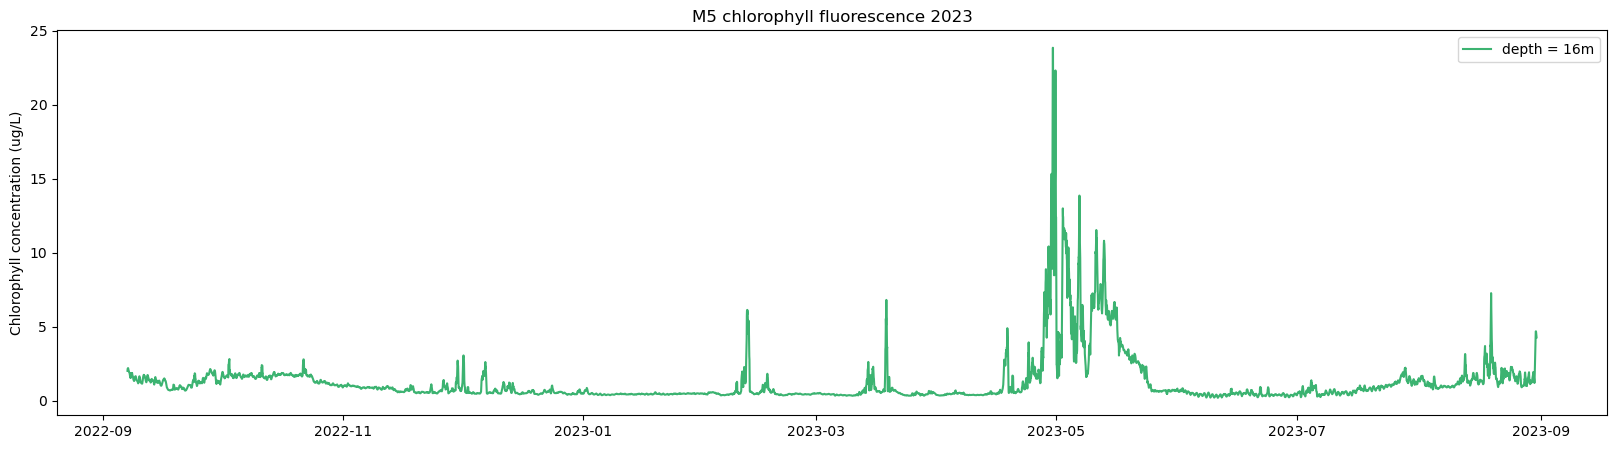

In [8]:
fig, ax1 = plt.subplots(figsize=(20,5))


ax1.plot(final_M5_chlor.index, final_M5_chlor['chl uG/L'].rolling(7).mean(), color='mediumseagreen')
ax1.set_ylabel('Chlorophyll concentration (ug/L)')
ax1.legend(['depth = 16m'])

plt.title('M5 chlorophyll fluorescence 2023')

In [9]:
# add in temperature data 

temp = M5_data_15m.temperature.values[:, 0, 0, 0]

time = M5_data_15m.temperature.time.values

np.shape(temp)
np.shape(time)


M5_temp = pd.DataFrame(data = temp, index= time, columns=['temperature'])
M5_temp_average = M5_temp.rolling(7).mean()

Text(0, 0.5, 'Temperature °C')

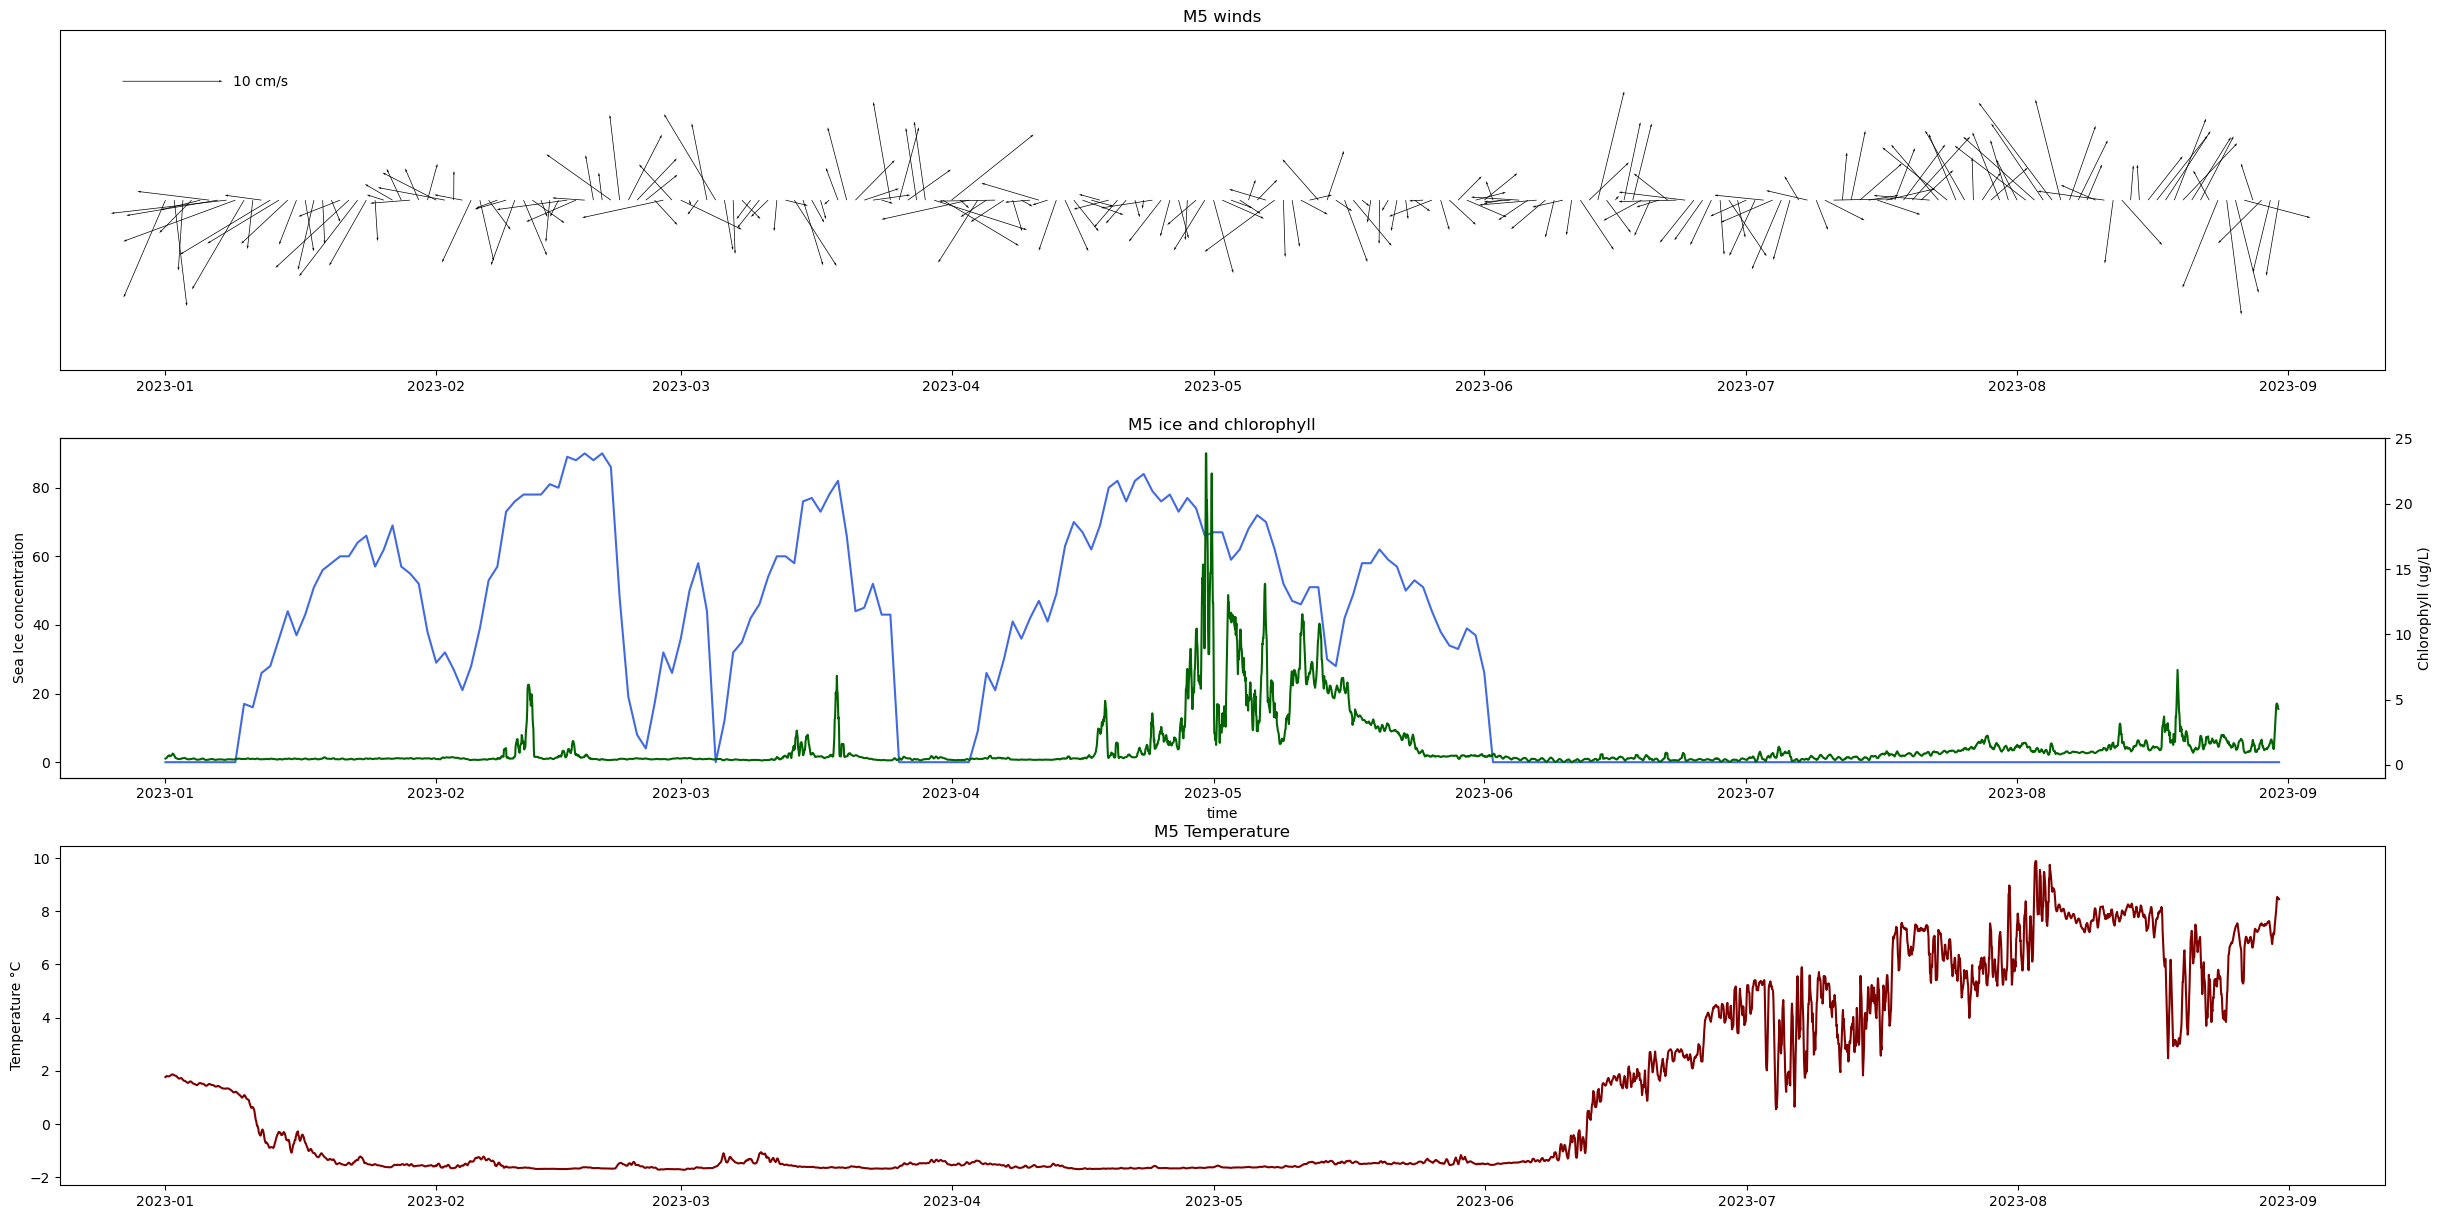

In [11]:
# add in wind data
M5_winds = pd.read_csv('/Users/anjalishah/Desktop/EcoFOCI2024/Data/Mooring_Sites/M5/M5_wnd.2023.csv')
M5_winds.index = pd.to_datetime(M5_winds['time'])
M5_winds = M5_winds.drop(columns = ['time'])

#define start and end date for plot
start_date = '2023-01-01'
end_date = '2023-08-31'

#define wind variables
x = np.array(M5_winds[start_date:end_date].index) #note for next time... when plotting timeseries 
u= pd.to_numeric(np.array(M5_winds[start_date:end_date]['uwnd'])) #E/W wind, positive is east
v = pd.to_numeric(np.array(M5_winds[start_date:end_date]['vwnd'])) #N/S wind, positive is north

#plot wind vectors
fig, ax = plt.subplots(3, 1, figsize=(30,15))
wind_plot = ax[0].quiver(x, np.zeros(len(x)), u, v, scale=10, scale_units='inches', width=.0003)
ax[0].set_title('M5 winds')
ax[0].quiverkey(wind_plot, 0.07, 0.85, U = 10, label ='10 cm/s', labelpos='E') 
ax[0].set_yticks([])
#ax.set_ylim(-100, 100)

#plot ice/chl timeseries
ax[1].set_xlabel('time')
ax[1].set_ylabel('Sea Ice concentration')
ax[1].set_title('M5 ice and chlorophyll')
ax[1].plot(M5_timeseries[start_date:end_date], color='royalblue')
ax[1] = ax[1].twinx()

ax[1].plot(final_M5_chlor_avg[start_date:end_date], color='darkgreen')
ax[1].set_ylabel('Chlorophyll (ug/L)')

ax[2].plot(M5_temp_average[start_date:end_date], color='maroon')
ax[2].set_title('M5 Temperature')
ax[2].set_ylabel('Temperature °C')


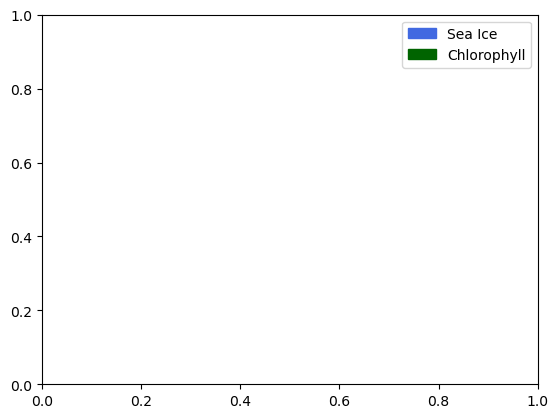

In [13]:
from matplotlib.patches import Patch

# Define the discrete colors and their labels
colors = ['royalblue', 'darkgreen']
labels = ['Sea Ice', 'Chlorophyll']

# Create the patches for each color
patches = [Patch(color=color, label=label) for color, label in zip(colors, labels)]

# Create a figure and axis
fig, ax = plt.subplots()

# Add the legend to the plot
ax.legend(handles=patches, loc='upper right')

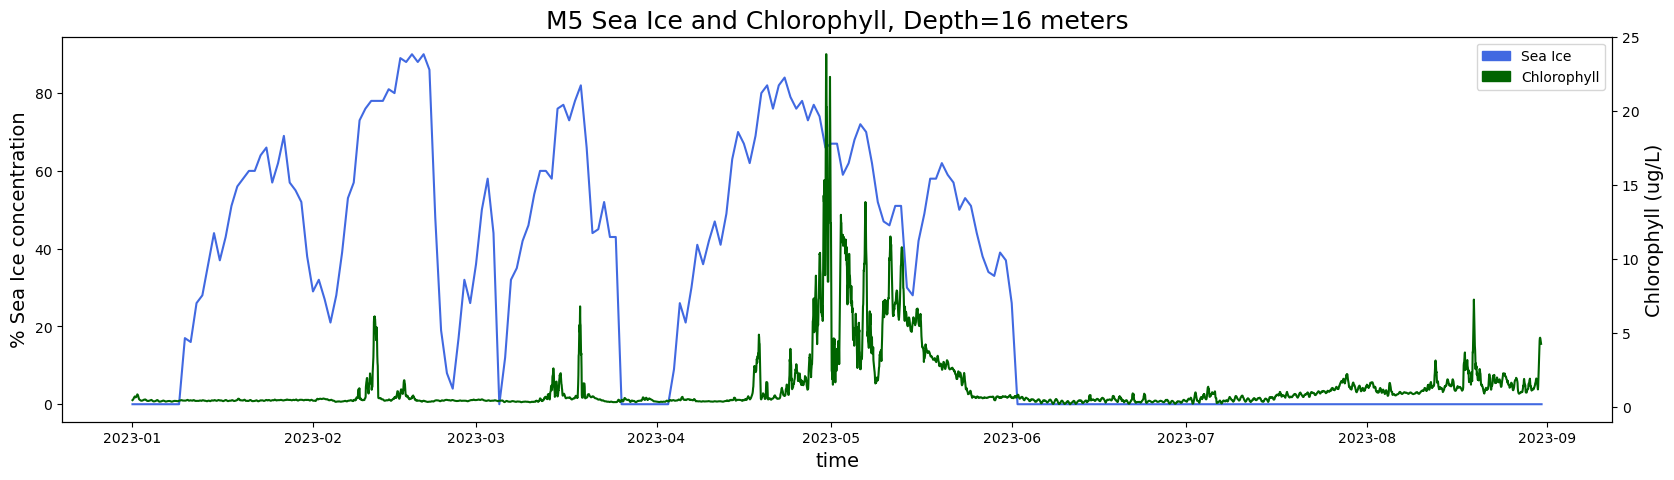

In [14]:
#plot ice/chl timeseries
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.set_xlabel('time', fontsize=14)
ax.set_ylabel('% Sea Ice concentration', fontsize=14)
ax.set_title('M5 Sea Ice and Chlorophyll, Depth=16 meters', fontsize=18)
ax.plot(M5_timeseries[start_date:end_date], color='royalblue')
ax = ax.twinx()
ax.set_ylabel('Chlorophyll (ug/L)', fontsize=14)
ax.legend(handles=patches, loc='upper right')
ax.plot(final_M5_chlor_avg[start_date:end_date], color='darkgreen')



In [9]:
# #align the dates correctly 
# padded_days = []
# M5_ice_dates = []

#     M5_ice_dates.append(datetime.strptime(str(padded_days[i-1]), '%j'))

# M5_ice.set_index([M5_ice_dates], inplace=True)
# M5_ice.index = M5_ice.index.astype(str)

# just_days = []

# print(len(M5_ice.index.values))

# for i in M5_ice.index.values:
#      just_days.append(i[5:10])

# M5_ice.set_index([just_days])

# for i in M5_ice.columns[2:,].values: 
#     pd.concat([M5_ice, M5_ice[i]], axis=0)
    
# M5_ice_2022 = pd.DataFrame(M5_ice['2022'])
# M5_ice_2023 = pd.DataFrame(M5_ice['2023'])

# new_indices_2022=[]
# new_indices_2023=[]
# for i, date in enumerate(M5_ice_2022.index.values):
#     if '1900' in date:
#         new_indices_2022.append('2022-' + date[5:10])
#     else:
#         new_indices_2022.append(date)

# for i, date in enumerate(M5_ice_2023.index.values):
#     if '1900' in date:
#         new_indices_2023.append('2023-' + date[5:10])
#     else:
#         new_indices_2023.append(date)

# M5_ice_2022.set_index([new_indices_2022])
# M5_ice_2023 = M5_ice_2023.set_index([new_indices_2023])

# new_indices =[]
# for i in M5_ice_2023.index.values:
#     new_indices.append(datetime.strptime(i, '%Y-%m-%d'))

# M5_ice_2023.set_index([new_indices])
# time_2023 = M5_ice_2023.index.values 

# plt.figure(figsize=(20,5))
# plt.plot(time_2023, M5_ice_2023, color='royalblue')
# plt.title('M5 ice 2023')
# plt.xlabel('time')
# plt.ylabel('Sea Ice concentration')
# interval = 50
# xtick_positions = np.arange(0, len(M5_ice_2023), interval)
# xtick_labels = [str(i) for i in M5_ice_2023.index.values ]  # Customize labels as needed
# # Apply the xticks to the plot
# plt.xticks(xtick_positions, xtick_labels)